In [1]:
import dask
import dask_awkward as dak
from coffea.dataset_tools import preprocess
from distributed import Client
from matplotlib import pyplot as plt

import egamma_tnp
from egamma_tnp.plot import plot_efficiency
from egamma_tnp.triggers import TagNProbeFromNTuples

In [2]:
ele32_filters = [
    "hltEG32L1SingleEGOrEtFilter",
    "hltEle32WPTightClusterShapeFilter",
    "hltEle32WPTightHEFilter",
    "hltEle32WPTightEcalIsoFilter",
    "hltEle32WPTightHcalIsoFilter",
    "hltEle32WPTightPixelMatchFilter",
    "hltEle32WPTightPMS2Filter",
    "hltEle32WPTightGsfOneOEMinusOneOPFilter",
    "hltEle32WPTightGsfMissingHitsFilter",
    "hltEle32WPTightGsfDetaFilter",
    "hltEle32WPTightGsfDphiFilter",
    "hltEle32WPTightGsfTrackIsoFilter",
]

In [3]:
ele32_filters = ["hltEle32WPTightGsfTrackIsoFilter"]

In [4]:
client = Client()

fileset = {
    "DY_LO_2023postBPIX": {
        "files": {"tnptuples/mc_DY_LO_2023postBPIX.root": "tnpEleTrig/fitter_tree"}
    },
    "DY_LO_MLL50_2024": {
        "files": {"tnptuples/mc_DY_LO_MLL50_2024.root": "tnpEleTrig/fitter_tree"}
    },
}

fileset_available, fileset_updates = preprocess(
    fileset, skip_bad_files=True, step_size=500_000
)

In [5]:
def pileup_filter(events, lower, upper):
    events = events[(events.truePU > lower) & (events.truePU <= upper)]
    return events

In [31]:
multiples_of_10 = list(range(0, 101, 10))
pairs_of_multiples = [
    (multiples_of_10[i], multiples_of_10[i + 1])
    for i in range(len(multiples_of_10) - 1)
]

In [ ]:
egamma_tnp.config.set(
    "ptbins",
    [
        5,
        10,
        12,
        14,
        16,
        18,
        20,
        23,
        26,
        28,
        30,
        32,
        34,
        36,
        38,
        40,
        45,
        50,
        60,
        80,
        100,
        150,
        250,
        400,
    ],
)

to_compute = {}

for filter in ele32_filters:
    tnp = TagNProbeFromNTuples(fileset_available, f"pass{filter.replace('hlt', 'HLT')}")
    to_compute[filter] = tnp.get_tnp_histograms(
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=35,
        uproot_options={"allow_read_errors_with_report": True},
    )

dak.necessary_columns(to_compute)

In [13]:
egamma_tnp.config.set(
    "ptbins",
    [
        5,
        10,
        12,
        14,
        16,
        18,
        20,
        23,
        26,
        28,
        30,
        32,
        34,
        36,
        38,
        40,
        45,
        50,
        60,
        80,
        100,
        150,
        250,
        400,
    ],
)

to_compute = {}
for filter in ele32_filters:
    to_compute[filter] = {}
    for pu_region in pairs_of_multiples:
        lower, upper = pu_region

        tnp = TagNProbeFromNTuples(
            fileset_available,
            f"pass{filter.replace('hlt', 'HLT')}",
            extra_filter=pileup_filter,
            extra_filter_args={"lower": lower, "upper": upper},
        )
        to_compute[filter][f"PU_{lower}_{upper}"] = tnp.get_tnp_histograms(
            eta_regions_pt={
                "barrel": [0.0, 1.4442],
                "endcap_loweta": [1.566, 2.0],
                "endcap_higheta": [2.0, 2.5],
            },
            plateau_cut=35,
            uproot_options={"allow_read_errors_with_report": True},
        )

dak.necessary_columns(to_compute)

{'from-uproot-b76c6f76b3bf0a2ce849ad24fd76e63f': frozenset({'el_eta',
            'el_phi',
            'el_pt',
            'pair_mass',
            'passHLTEle32WPTightGsfTrackIsoFilter',
            'passingCutBasedTight122XV1',
            'tag_Ele_pt',
            'truePU'}),
 'from-uproot-25cc5bd7cd29137ebf078d6f11e0ad28': frozenset({'el_eta',
            'el_phi',
            'el_pt',
            'pair_mass',
            'passHLTEle32WPTightGsfTrackIsoFilter',
            'passingCutBasedTight122XV1',
            'tag_Ele_pt',
            'truePU'})}

In [14]:
%%time

out = dask.compute(to_compute)[0]

CPU times: user 11.4 s, sys: 225 ms, total: 11.6 s
Wall time: 12.9 s


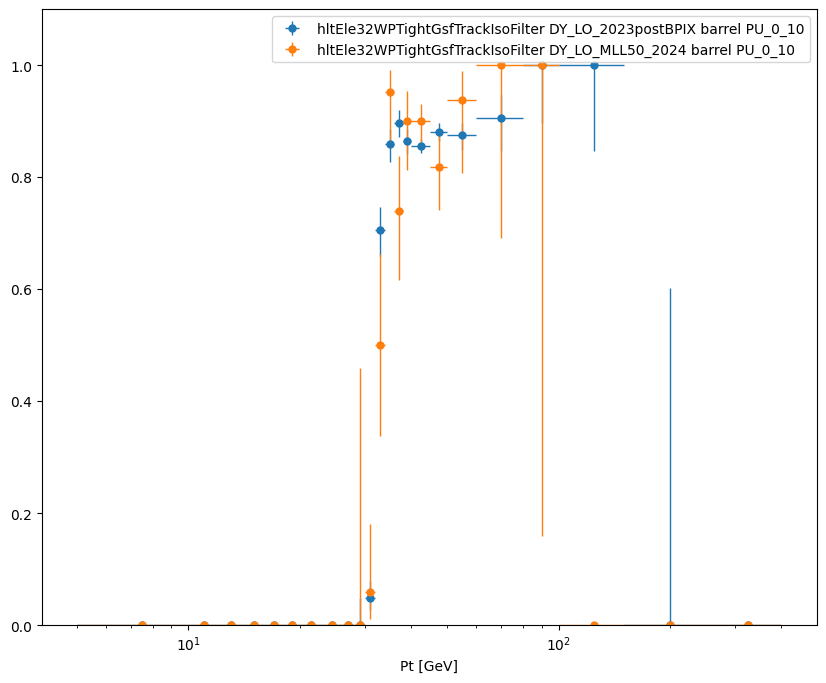

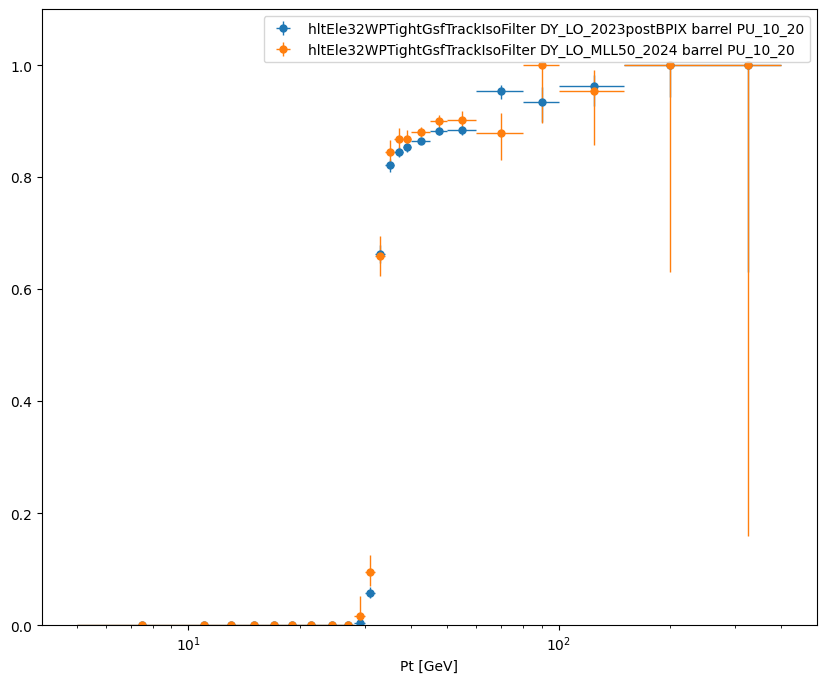

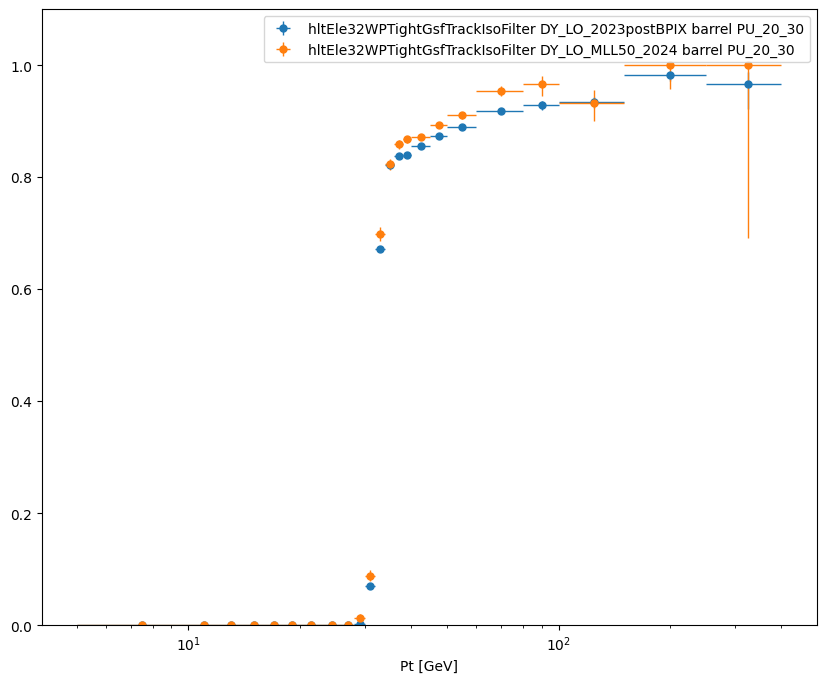

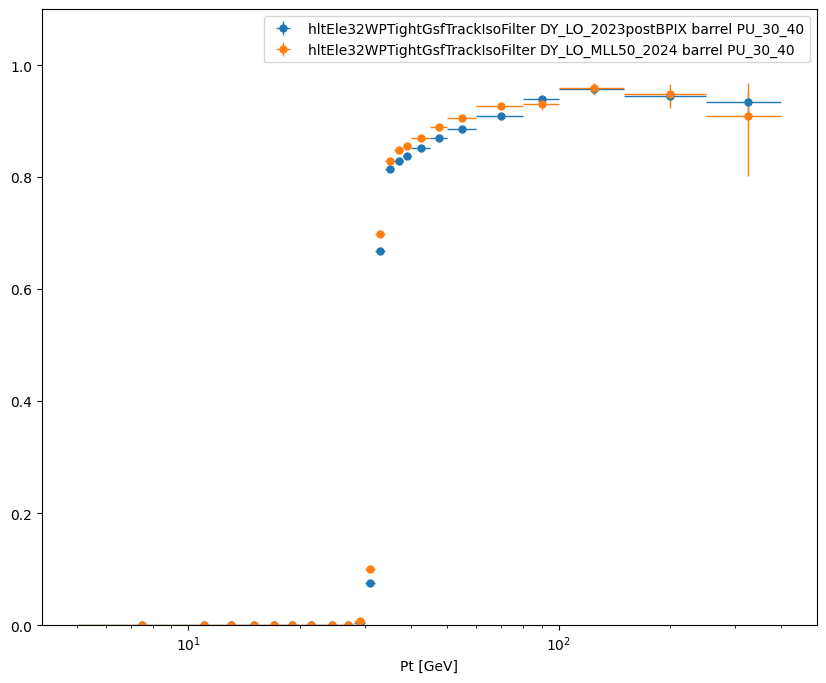

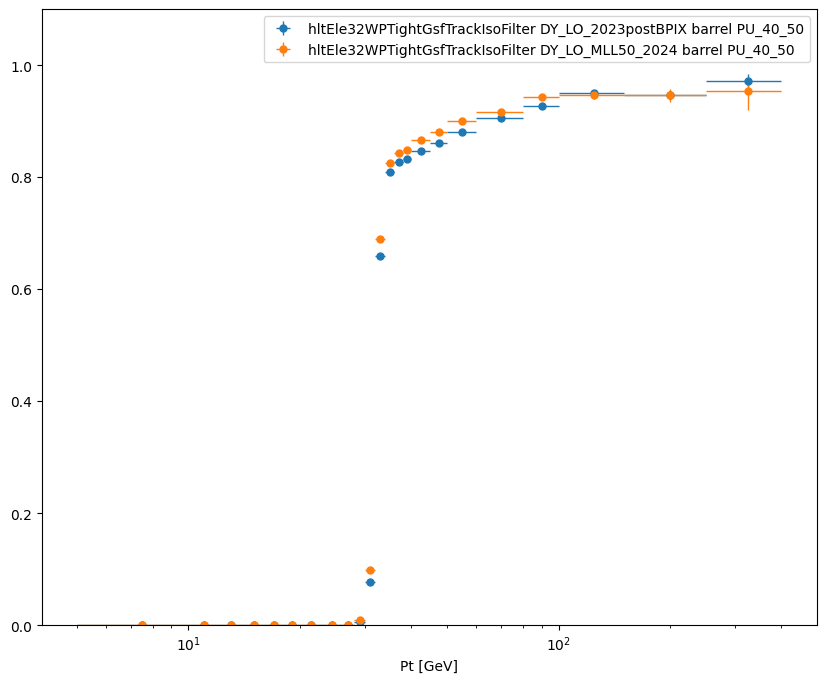

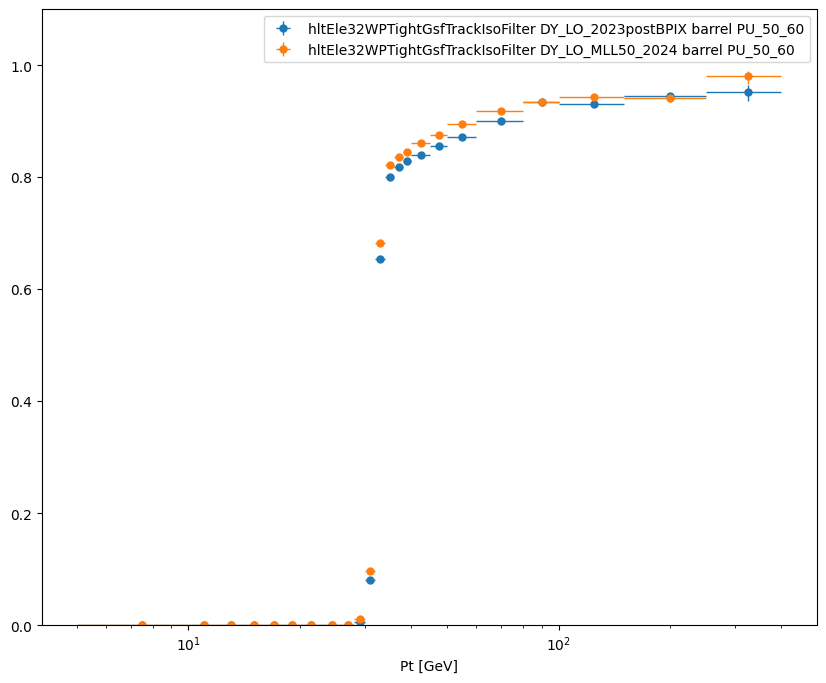

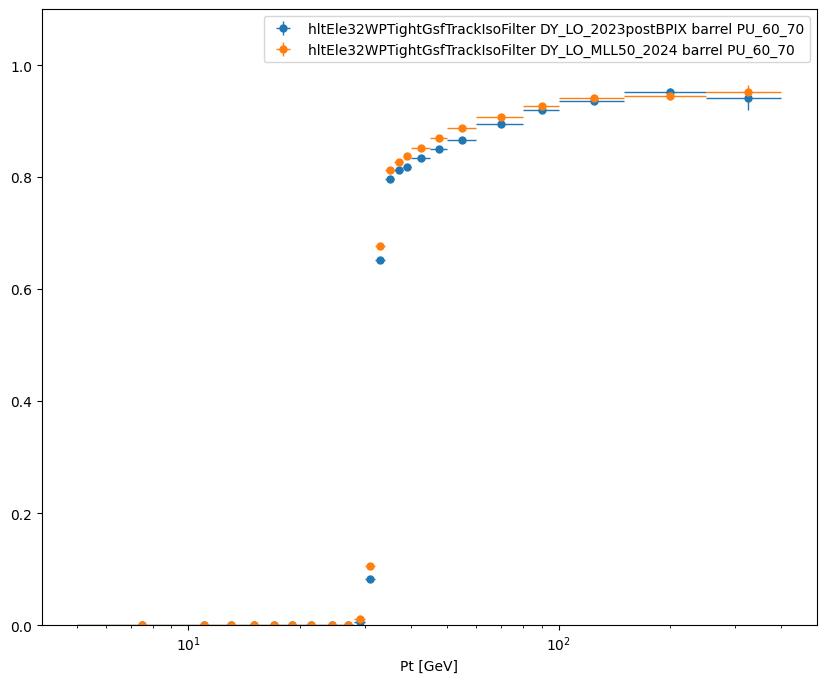

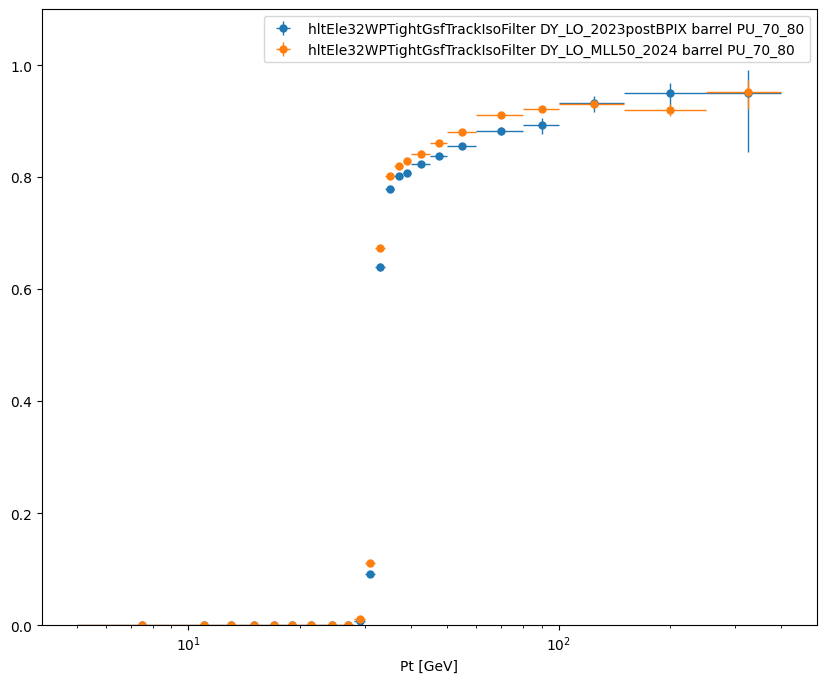

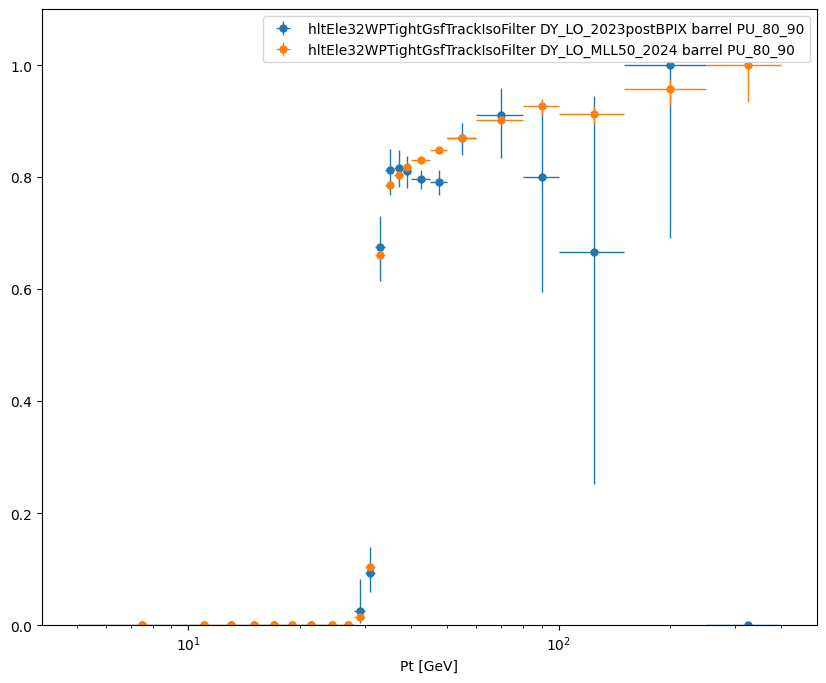

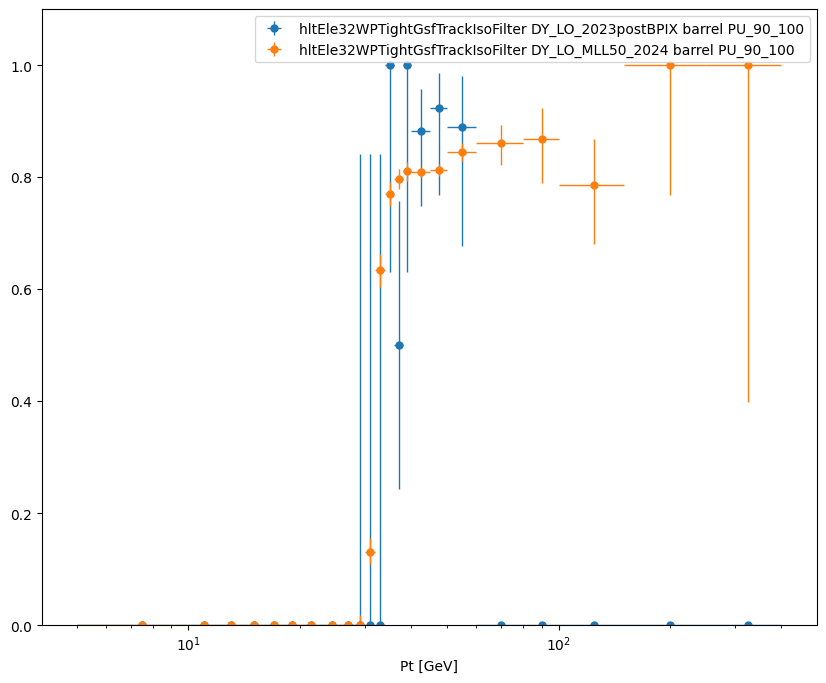

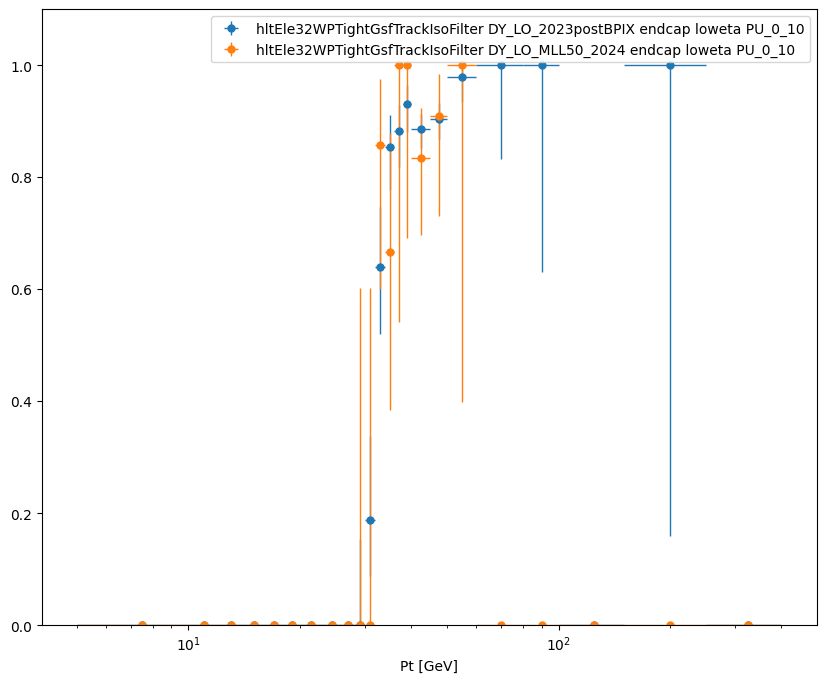

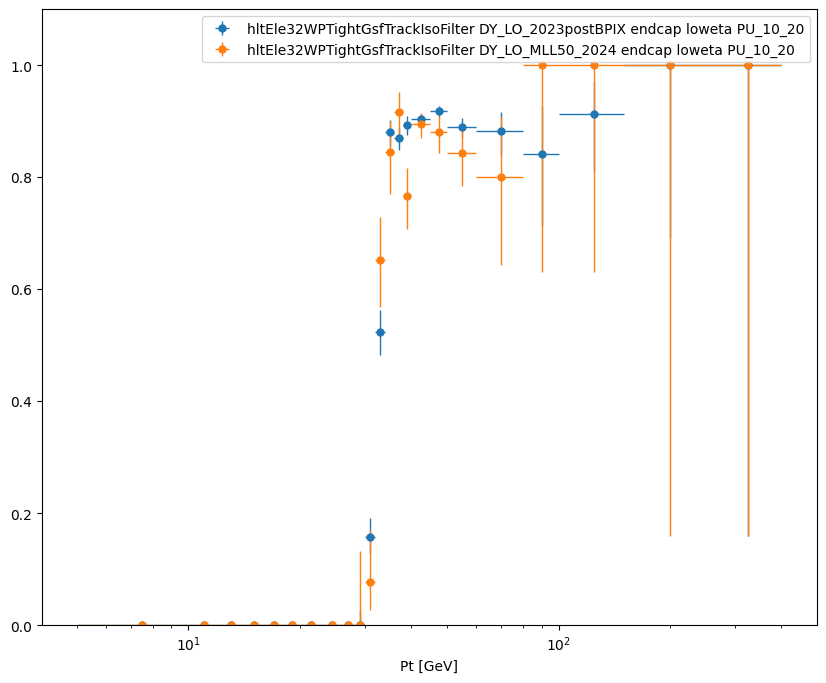

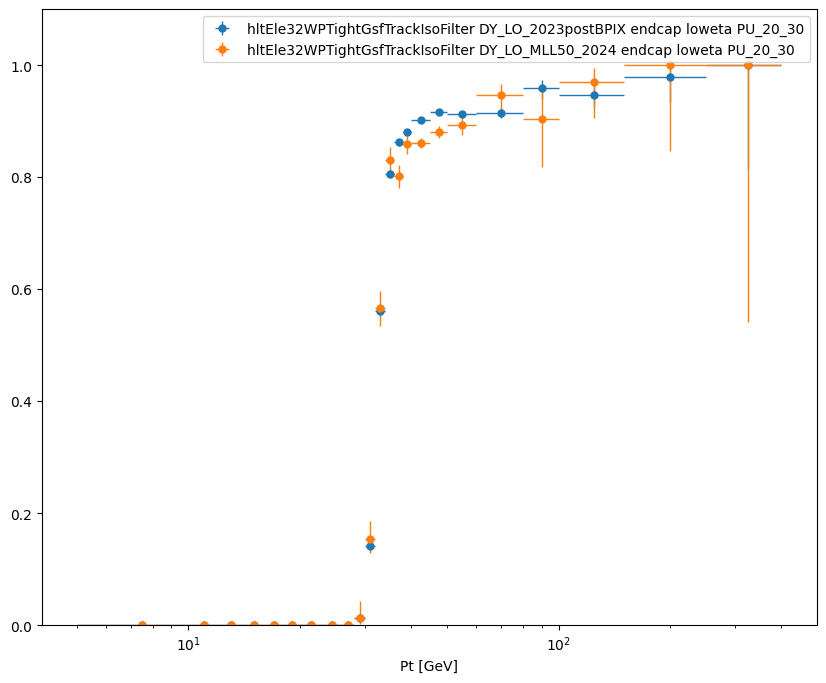

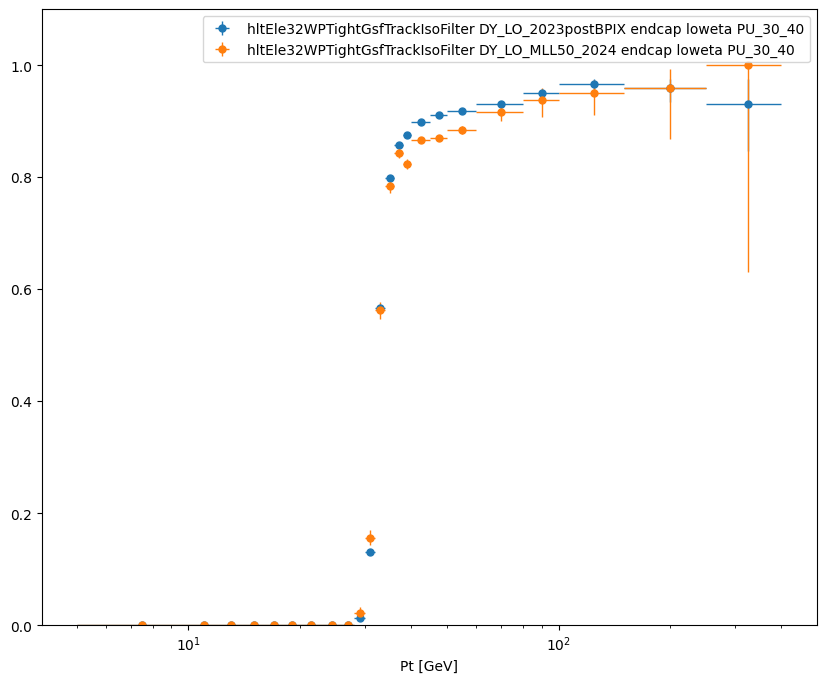

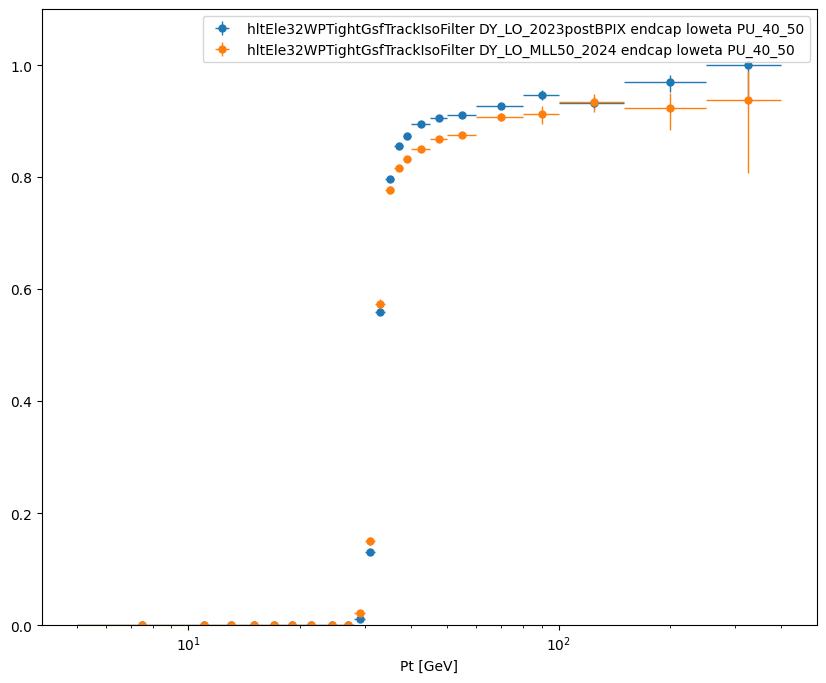

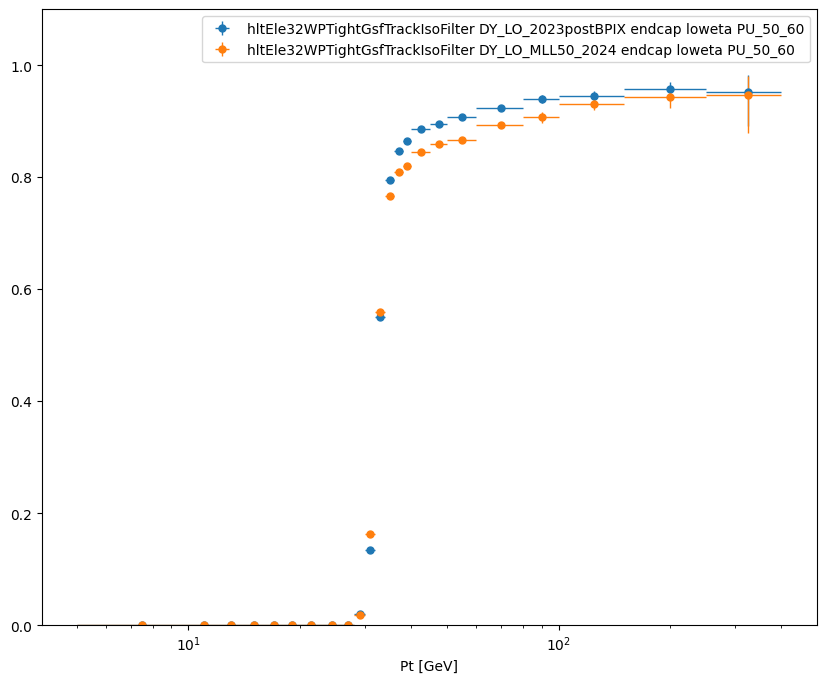

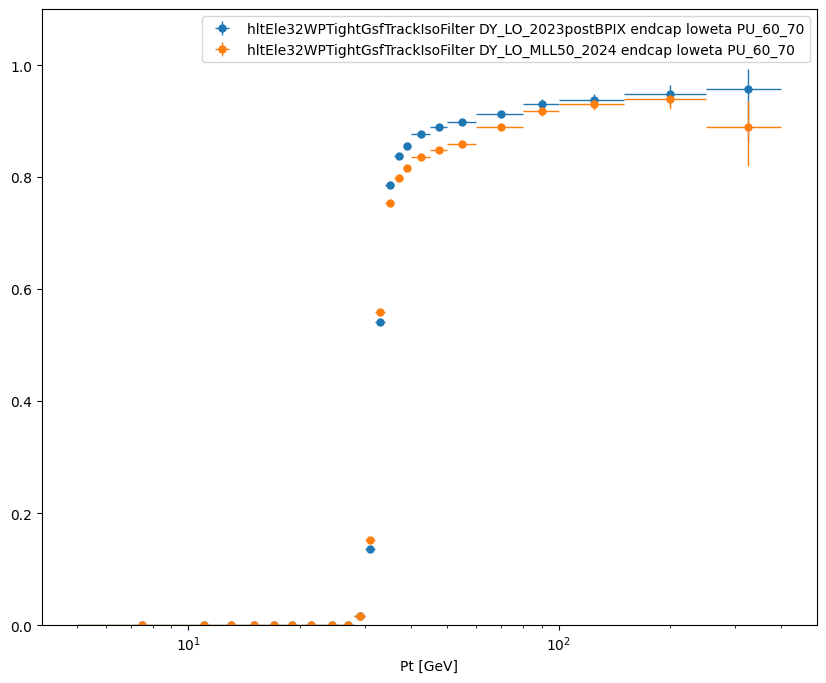

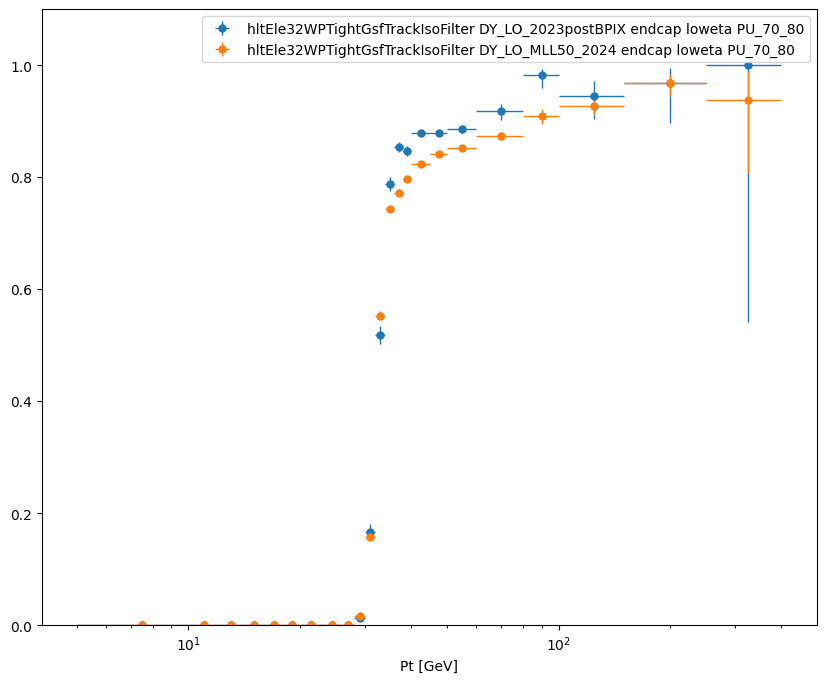

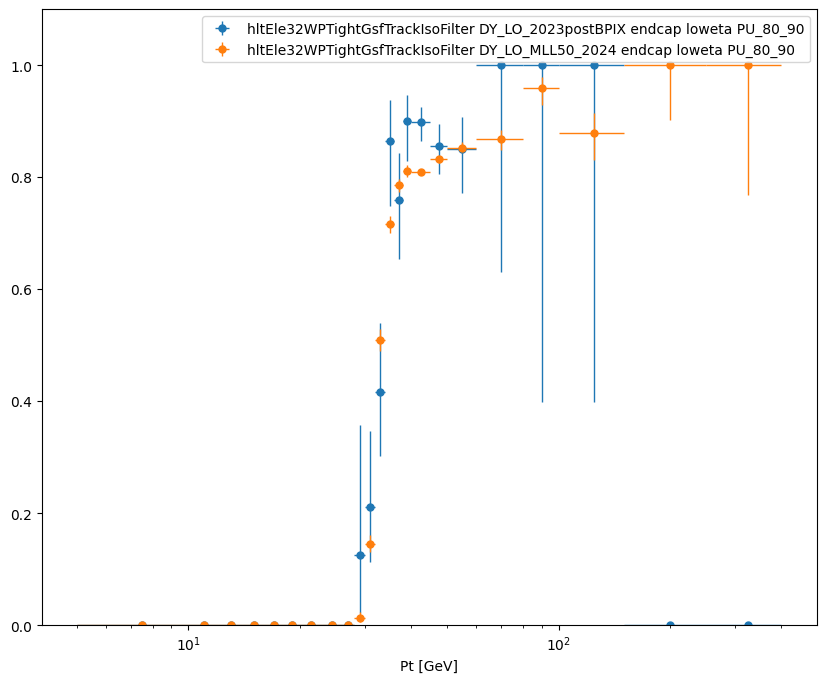

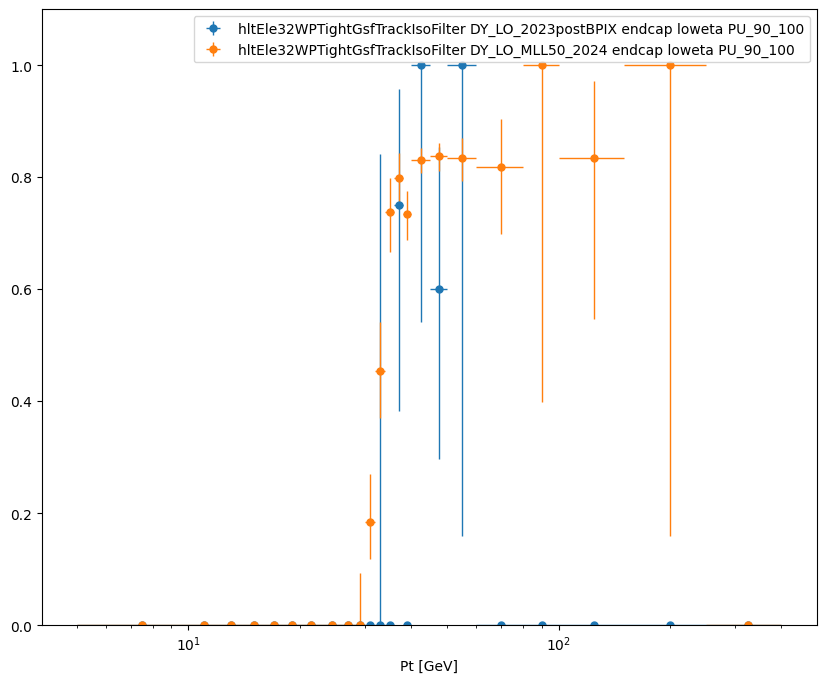

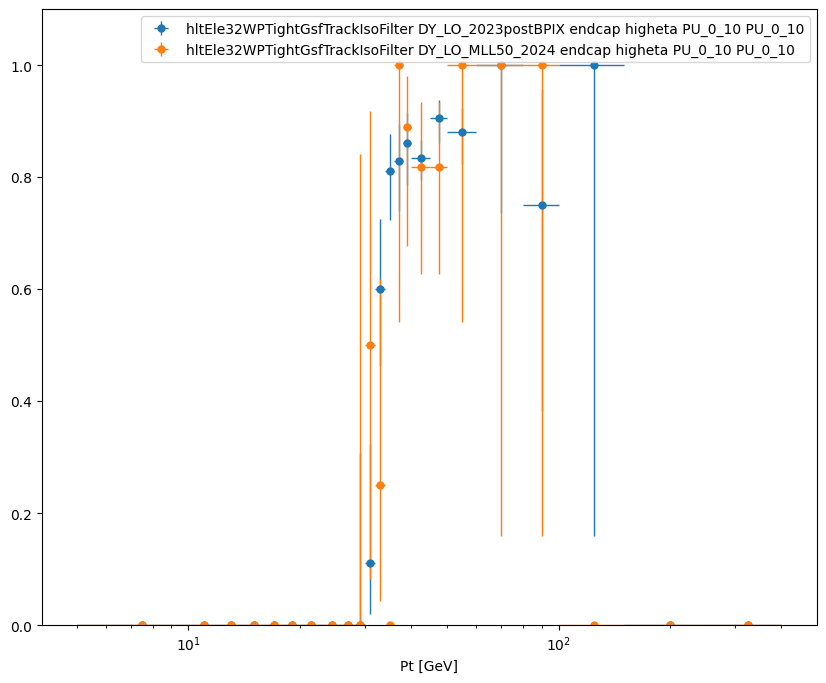

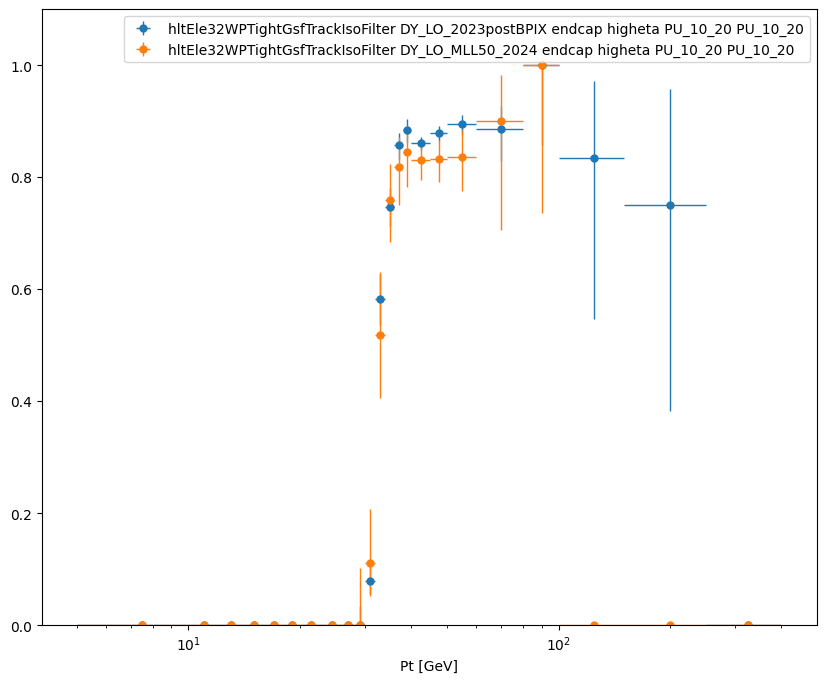

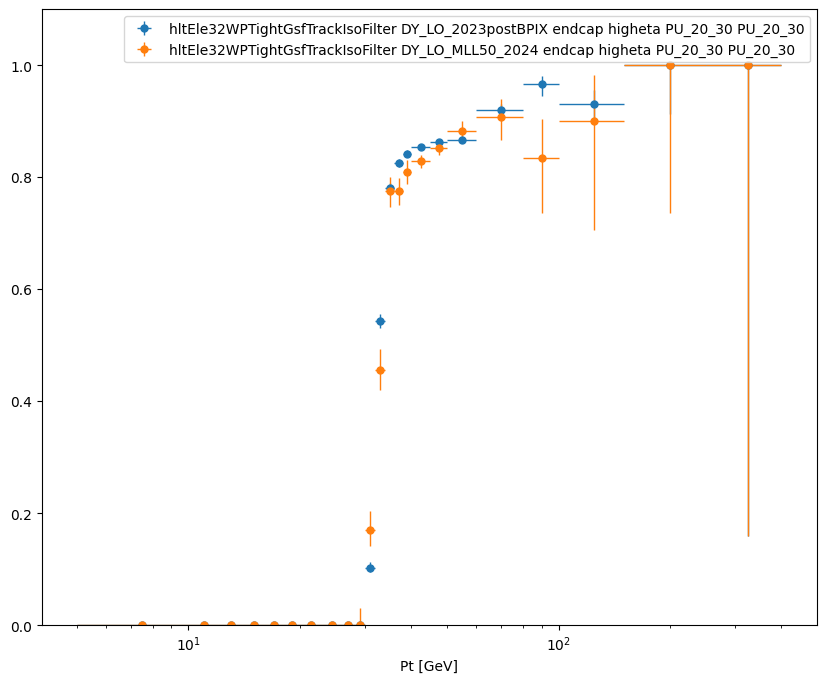

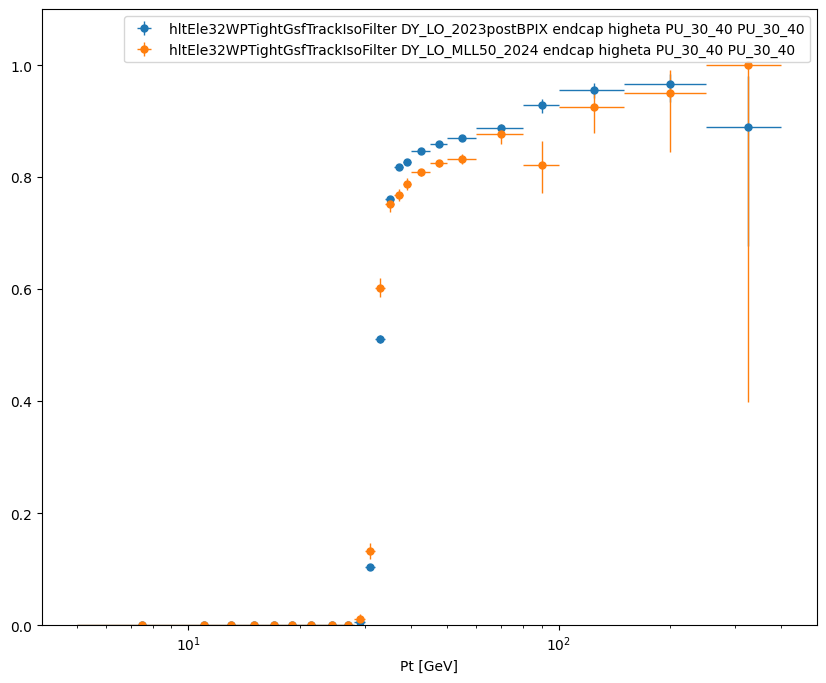

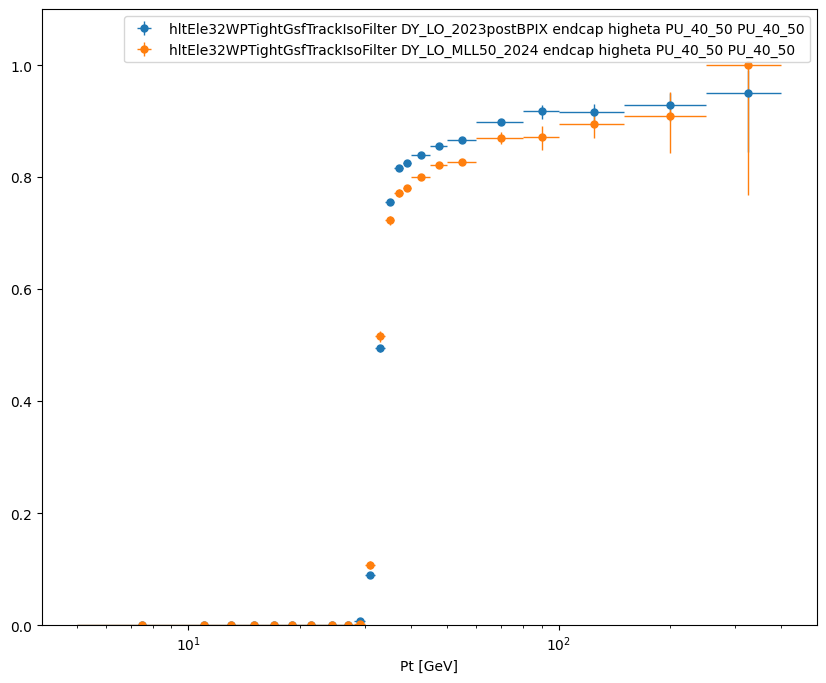

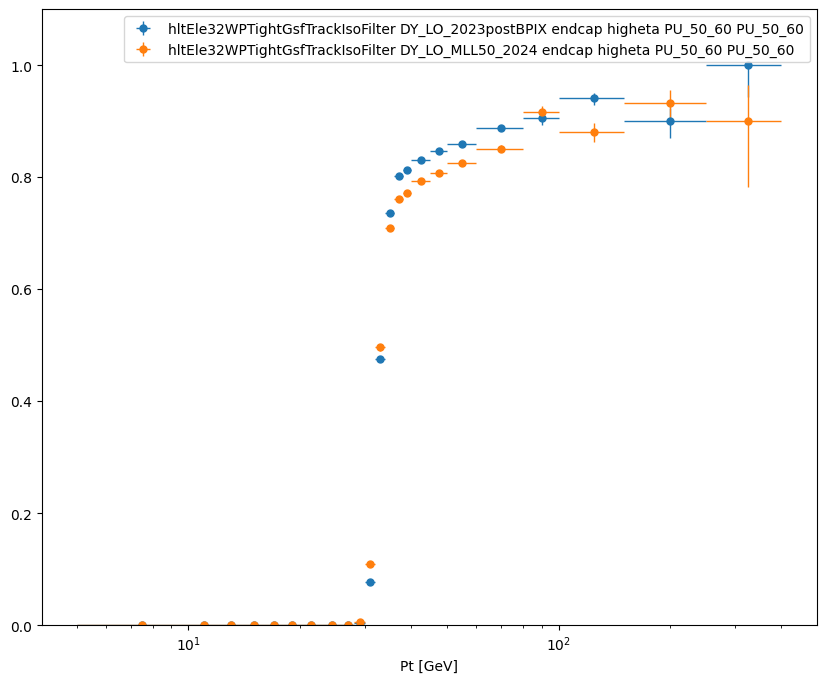

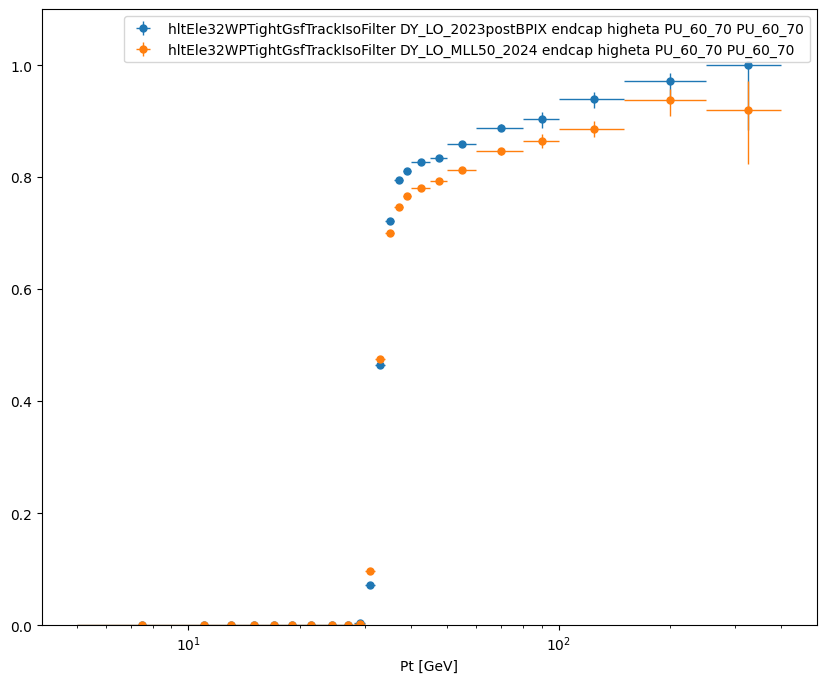

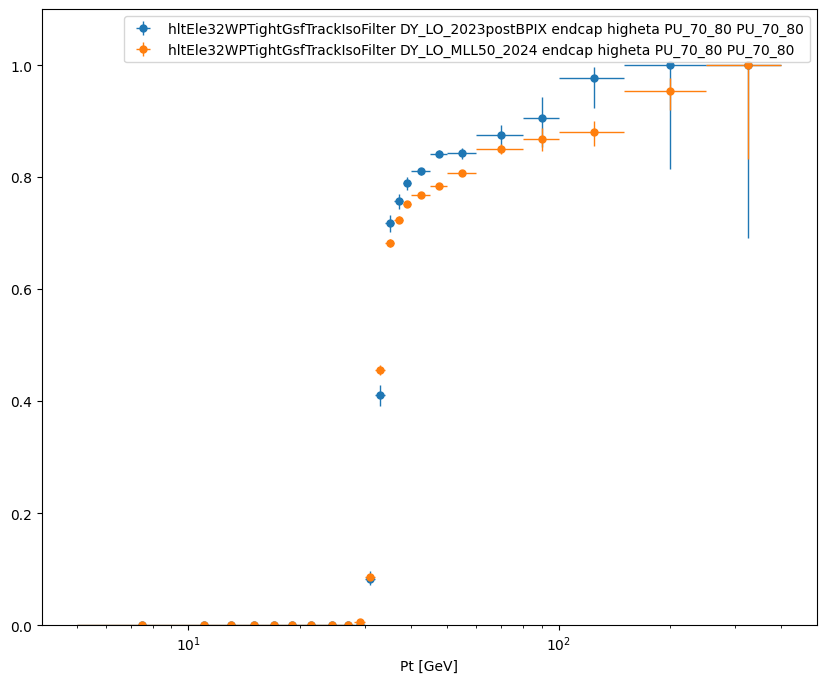

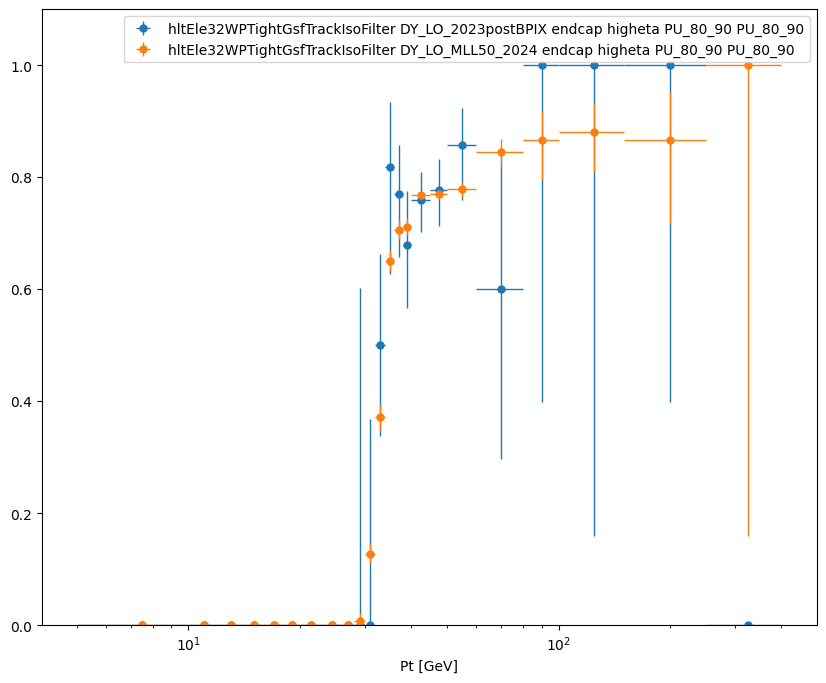

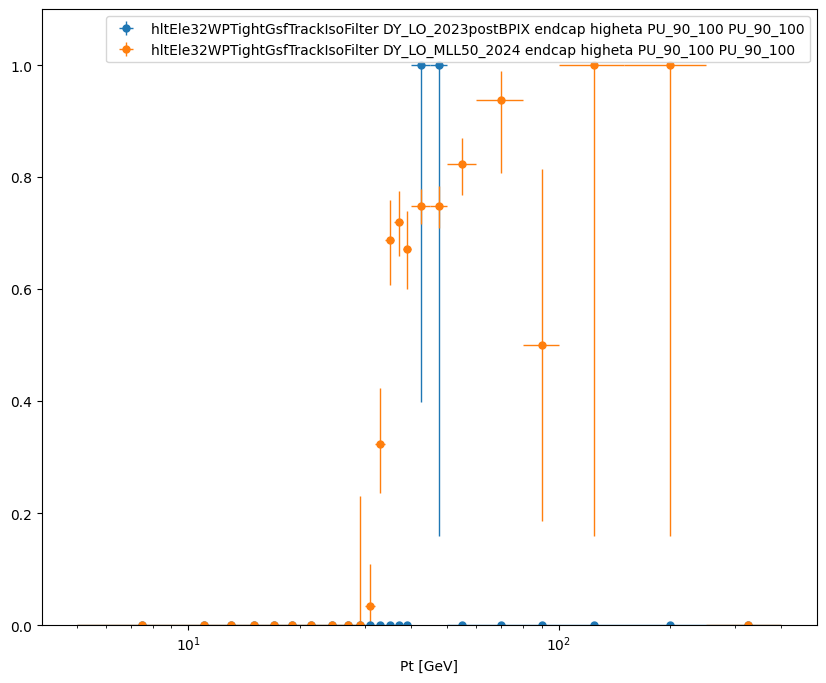

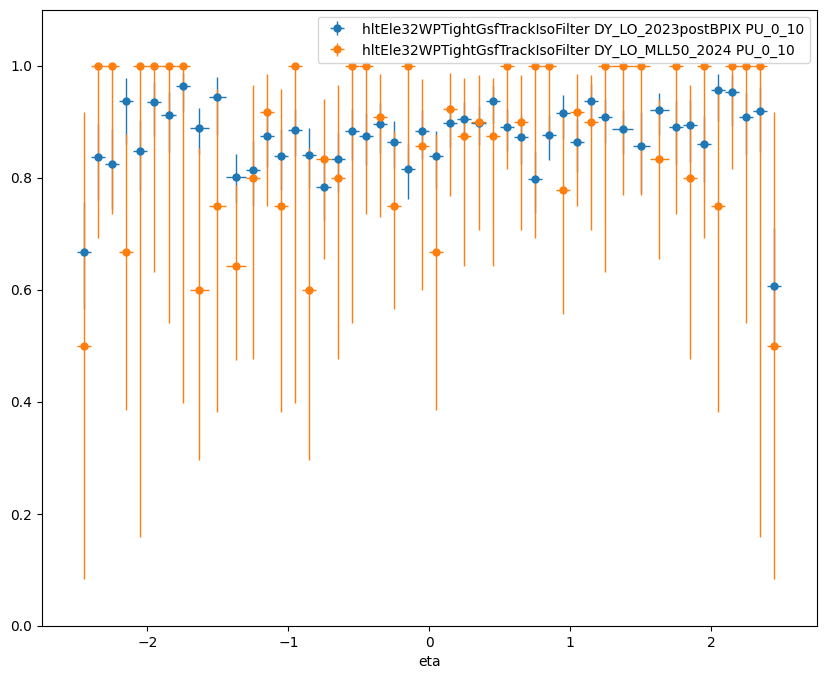

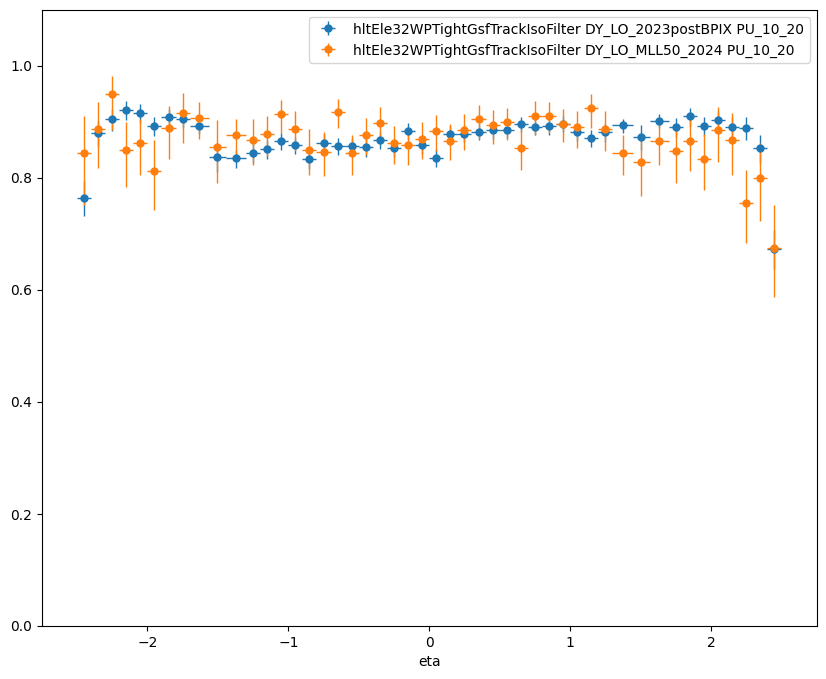

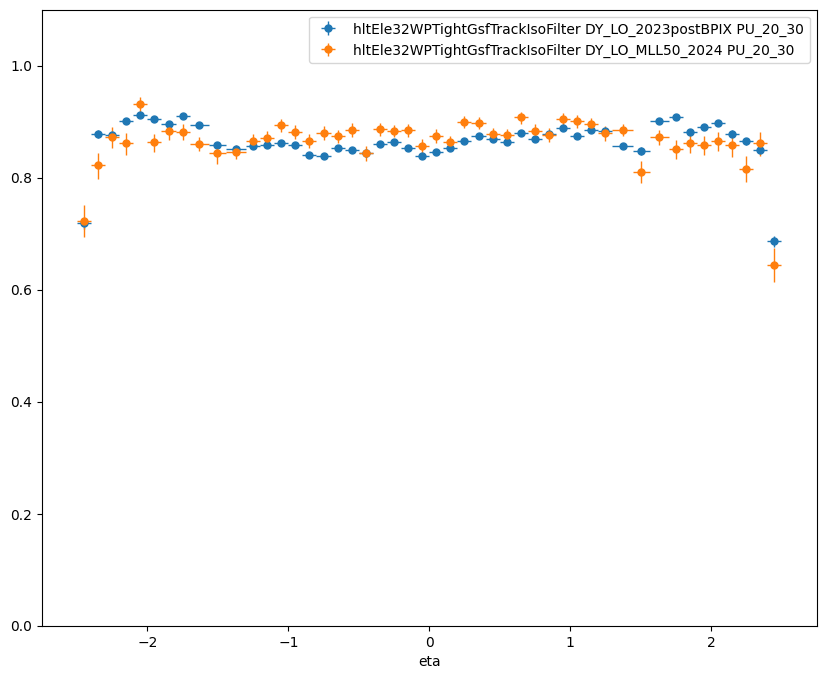

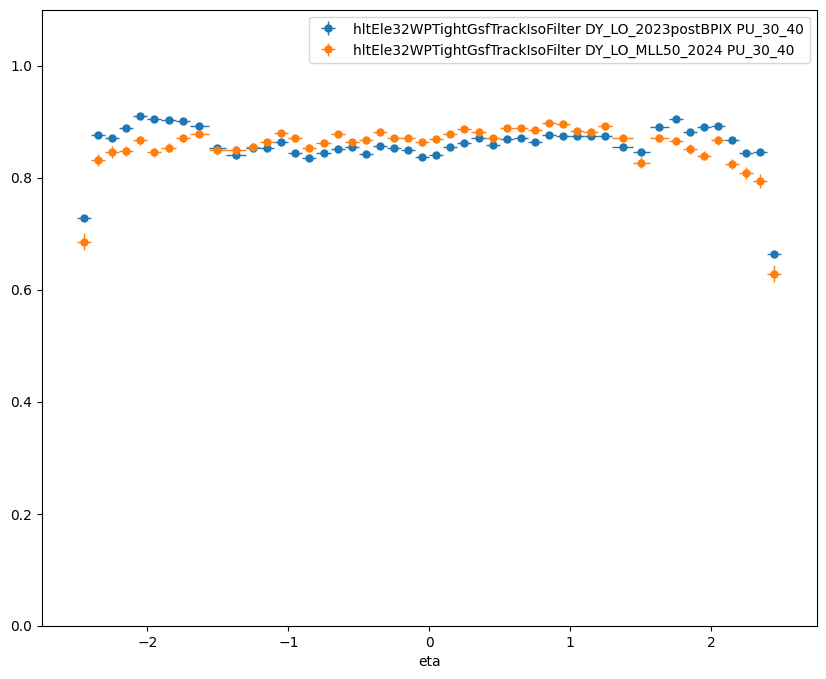

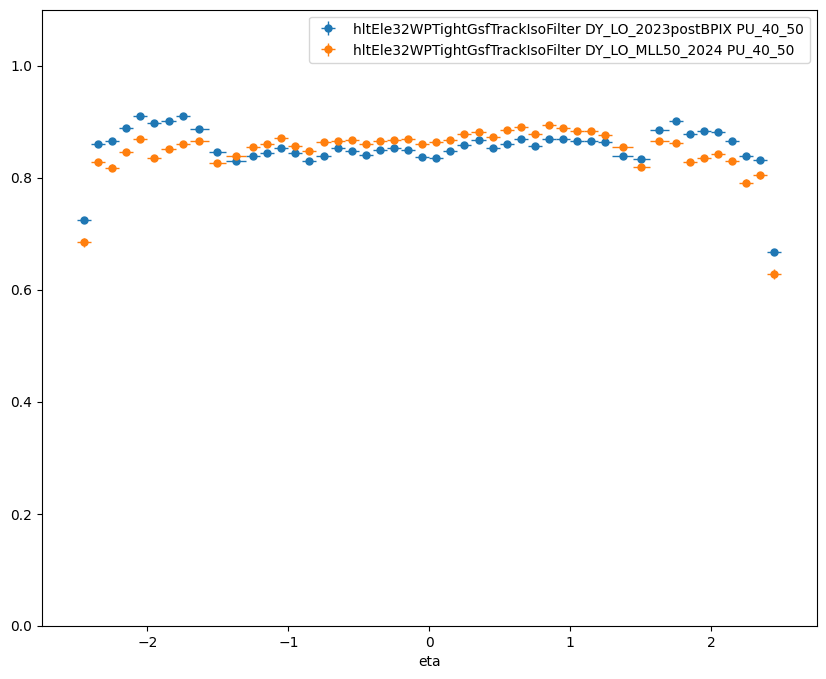

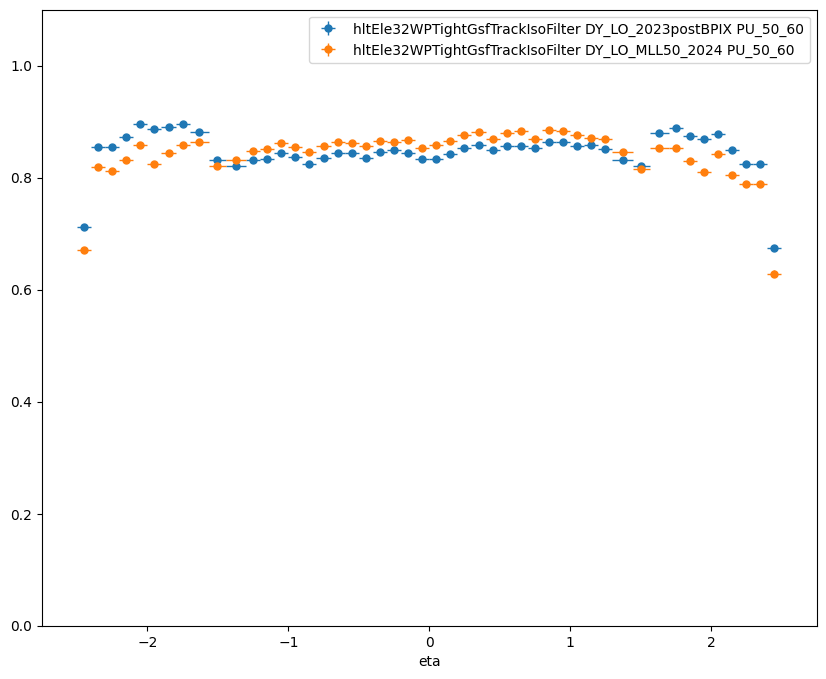

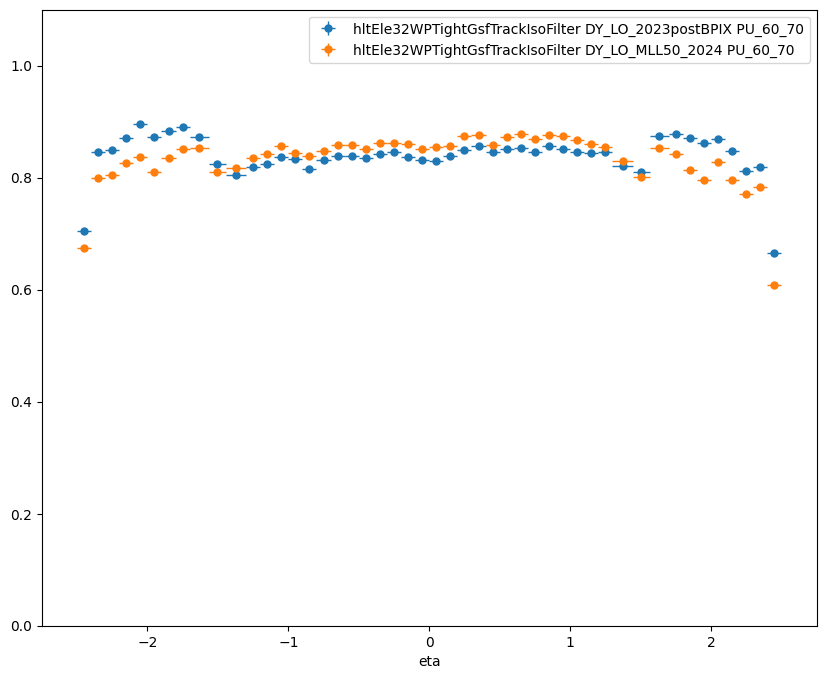

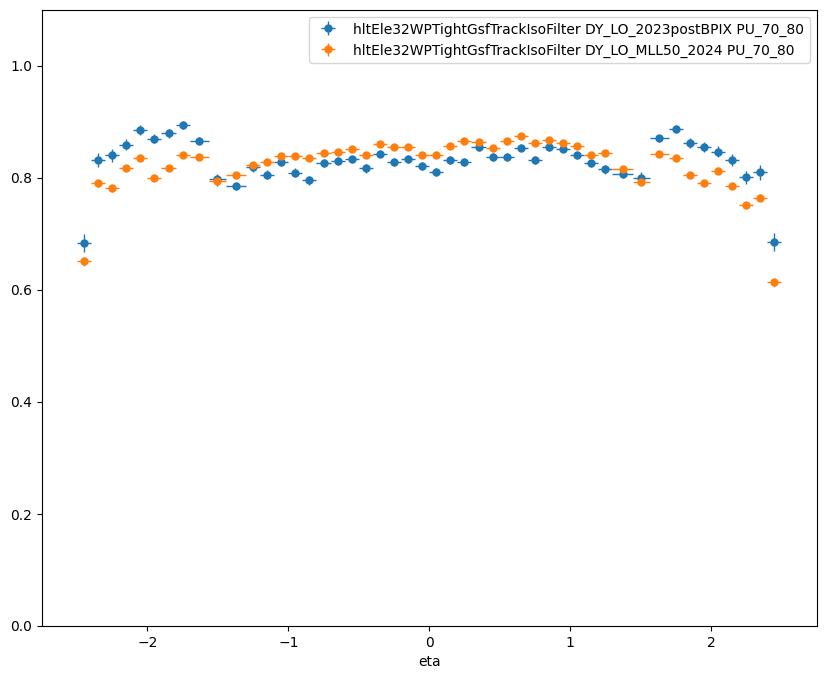

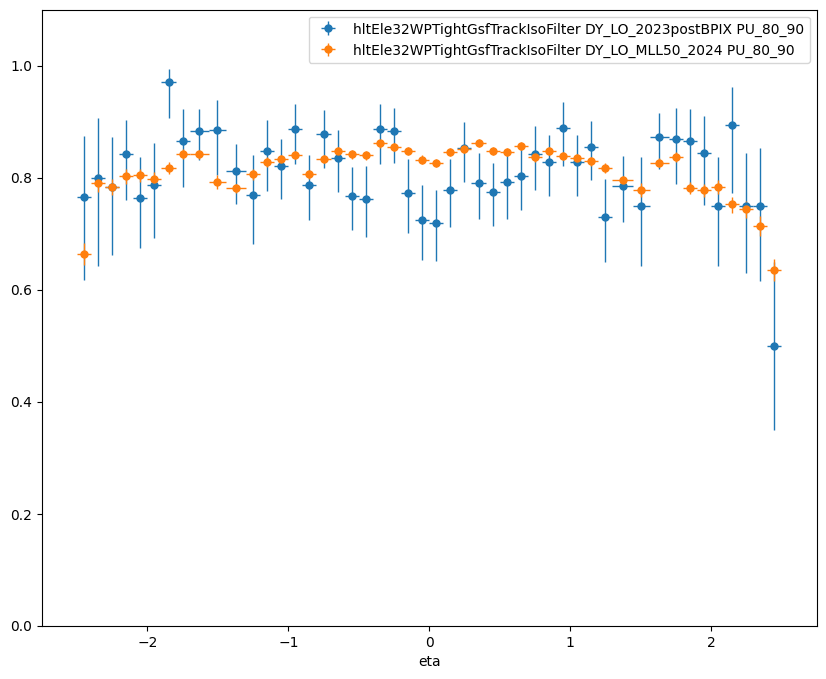

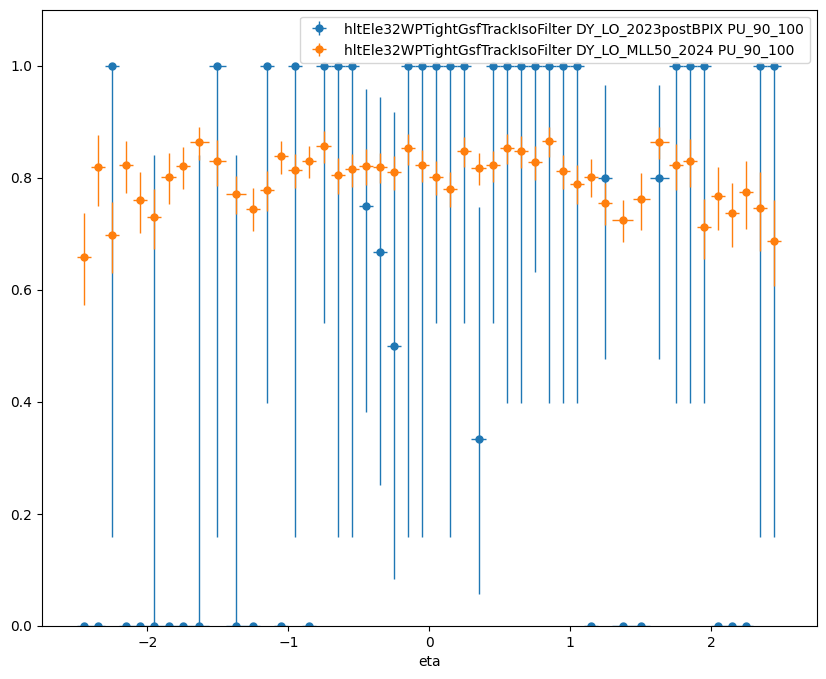

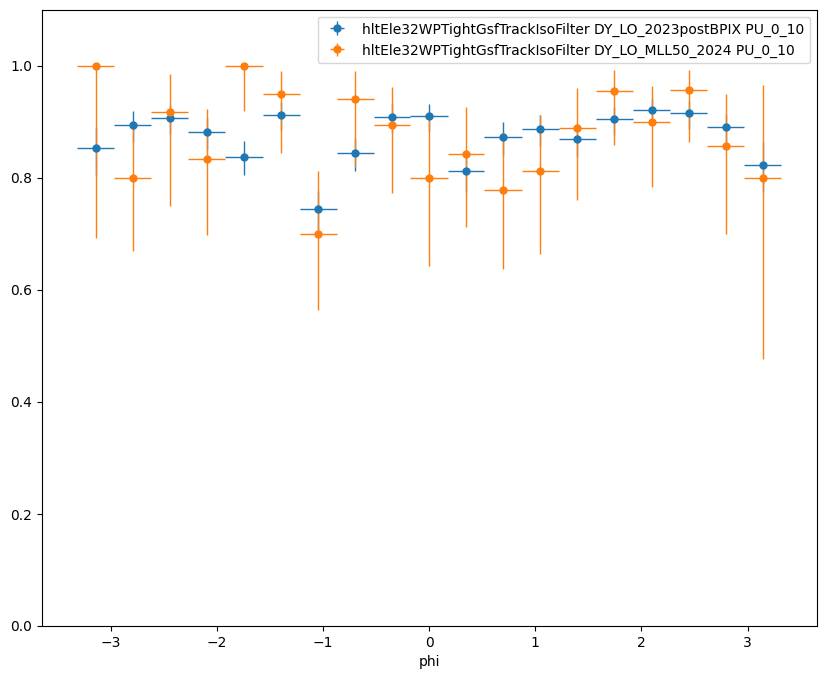

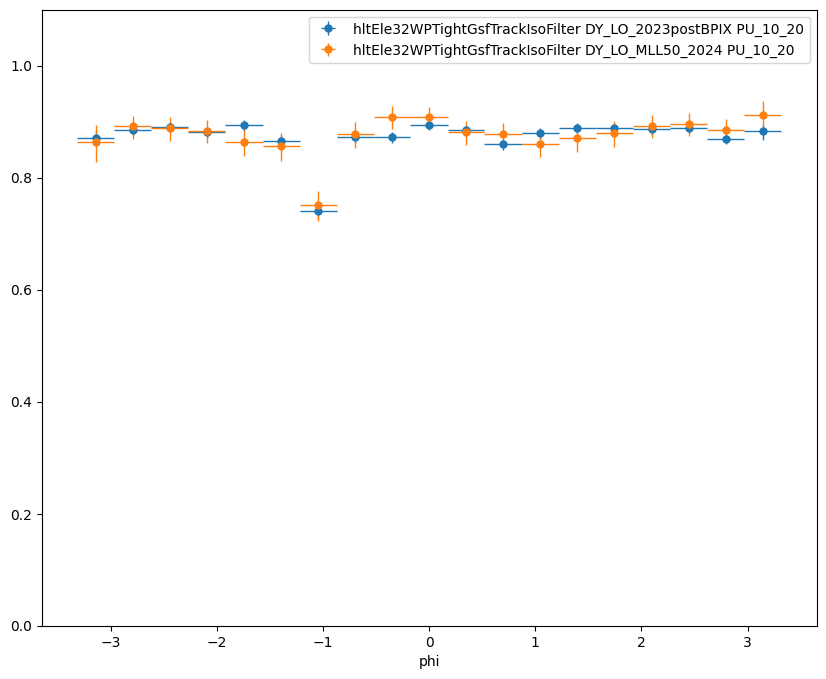

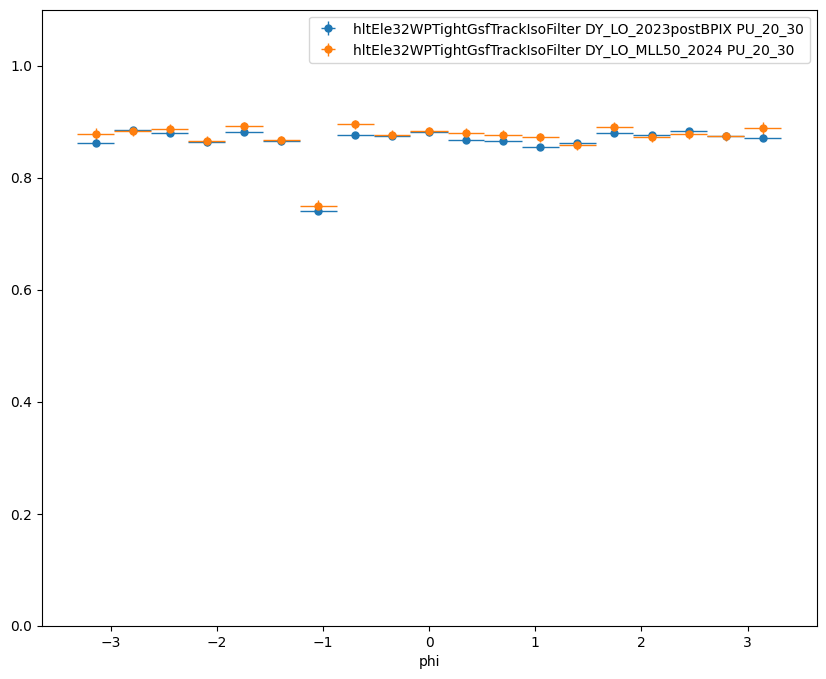

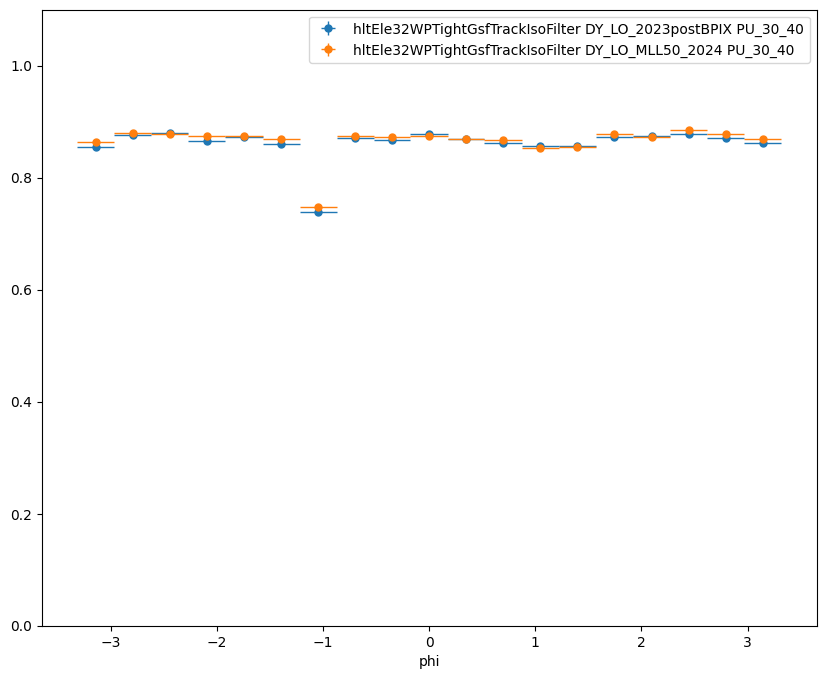

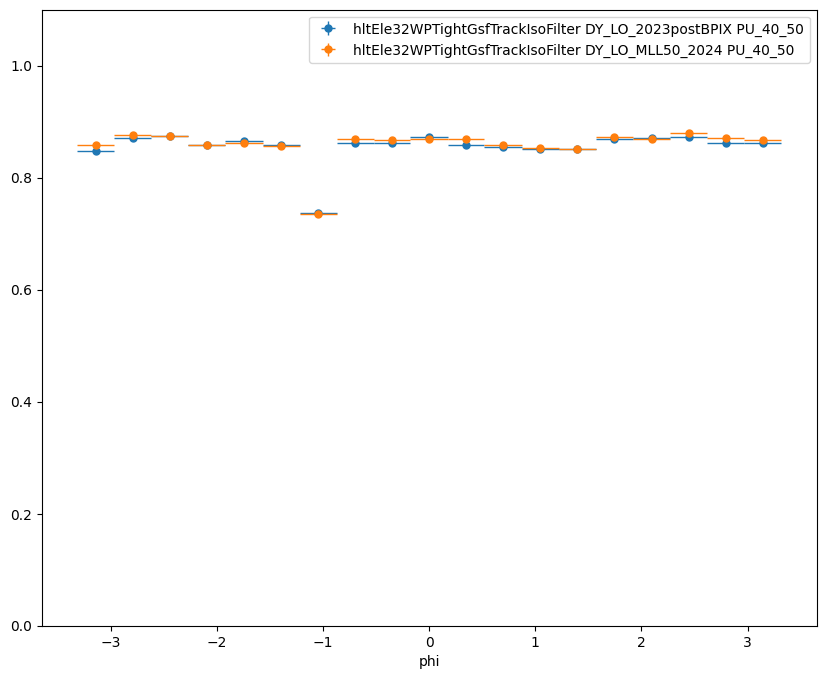

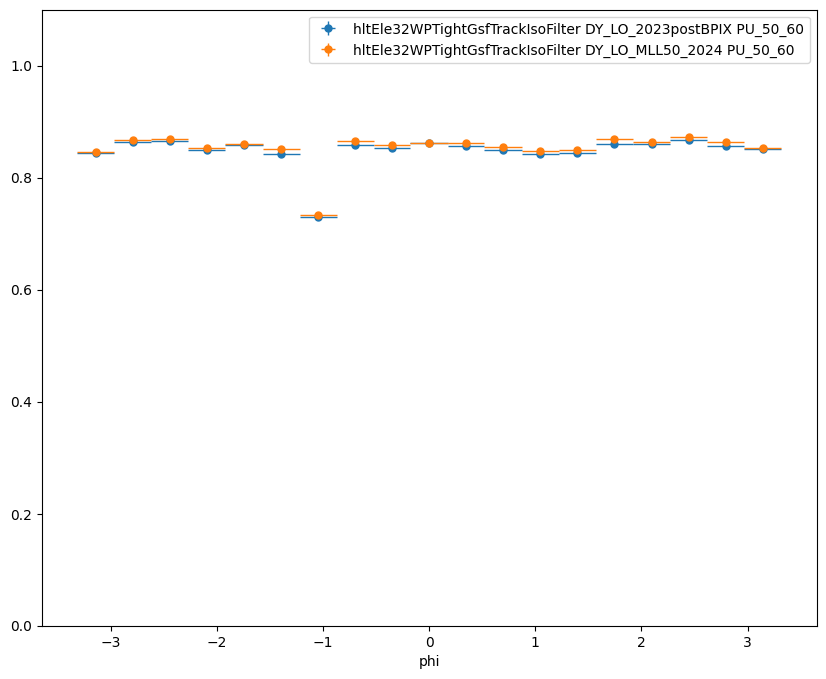

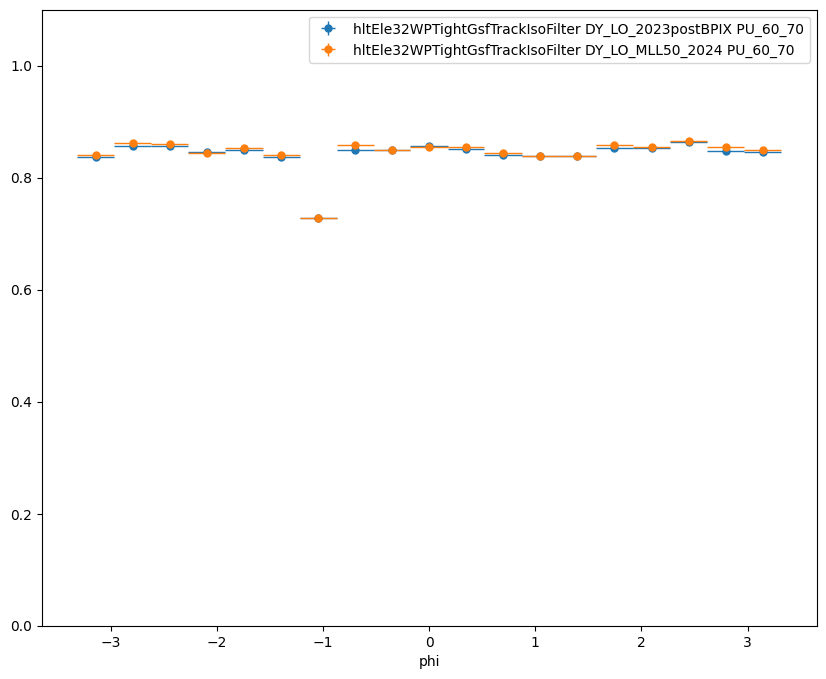

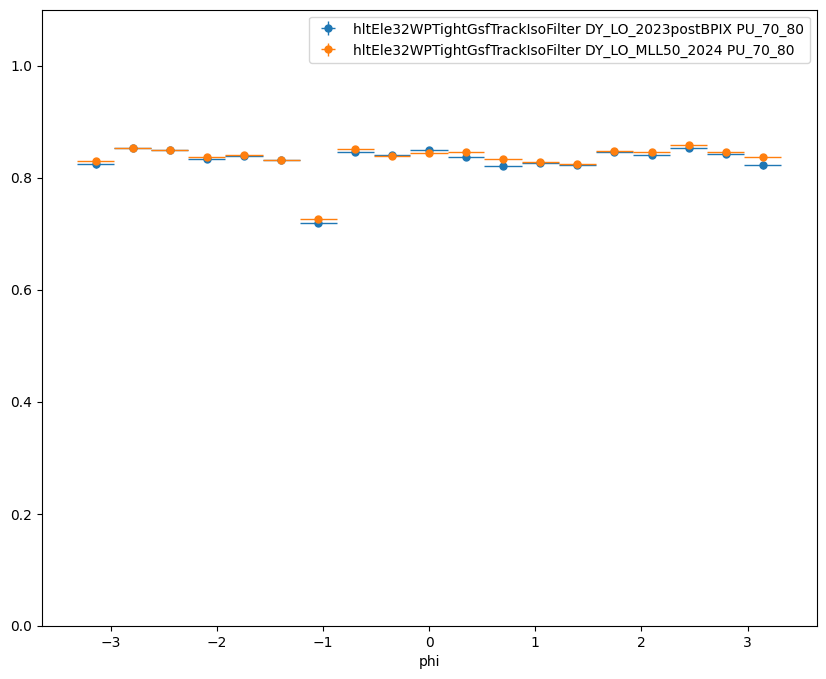

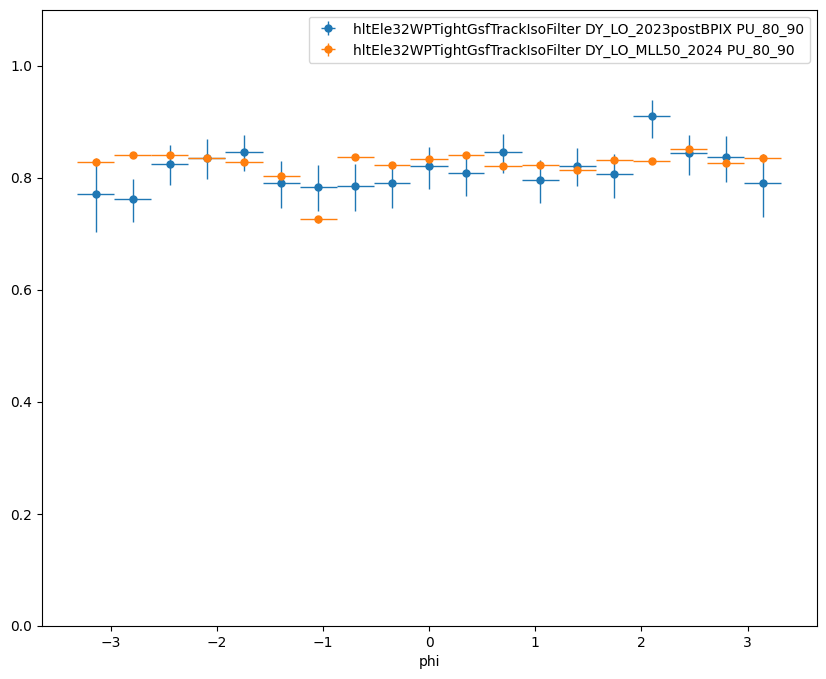

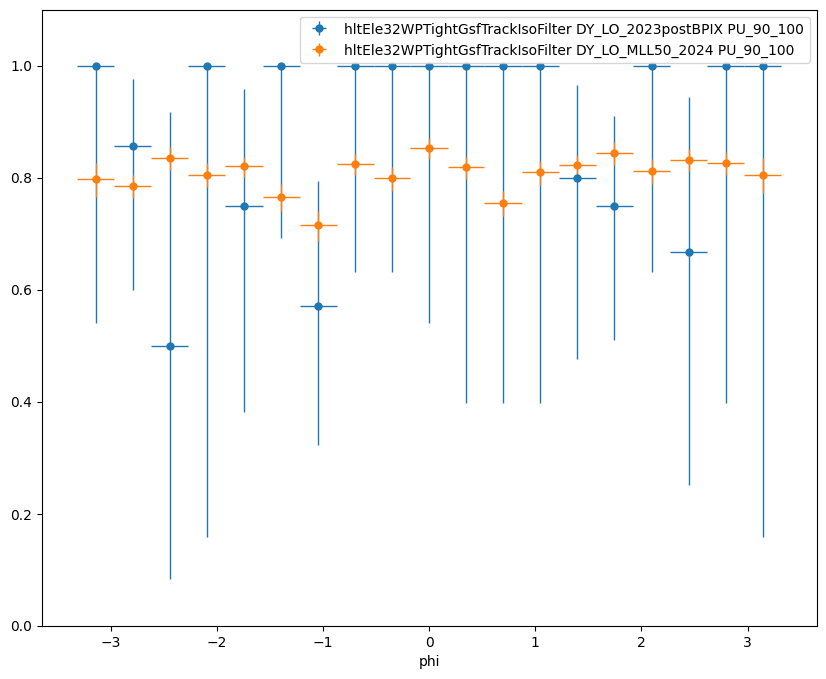

In [28]:
for filter in ele32_filters:
    for pu_region, other in out[filter].items():
        all_hists = other[0]
        plt.figure(figsize=(10, 8))
        for dataset, hists in all_hists.items():
            plot_efficiency(
                hists["pt"]["barrel"]["passing"],
                hists["pt"]["barrel"]["all"],
                label=f"{filter} {dataset} barrel {pu_region}",
            )
        plt.ylim(0, 1.1)
        plt.xscale("log")
        plt.legend()
        plt.show()

    for pu_region, other in out[filter].items():
        all_hists = other[0]
        plt.figure(figsize=(10, 8))
        for dataset, hists in all_hists.items():
            plot_efficiency(
                hists["pt"]["endcap_loweta"]["passing"],
                hists["pt"]["endcap_loweta"]["all"],
                label=f"{filter} {dataset} endcap loweta {pu_region}",
            )
        plt.ylim(0, 1.1)
        plt.xscale("log")
        plt.legend()
        plt.show()

    for pu_region, other in out[filter].items():
        all_hists = other[0]
        plt.figure(figsize=(10, 8))
        for dataset, hists in all_hists.items():
            plot_efficiency(
                hists["pt"]["endcap_higheta"]["passing"],
                hists["pt"]["endcap_higheta"]["all"],
                label=f"{filter} {dataset} endcap higheta {pu_region} {pu_region}",
            )
        plt.ylim(0, 1.1)
        plt.xscale("log")
        plt.legend()
        plt.show()

    for pu_region, other in out[filter].items():
        all_hists = other[0]
        plt.figure(figsize=(10, 8))
        for dataset, hists in all_hists.items():
            plot_efficiency(
                hists["eta"]["entire"]["passing"],
                hists["eta"]["entire"]["all"],
                label=f"{filter} {dataset} {pu_region}",
            )
        plt.ylim(0, 1.1)
        plt.legend()
        plt.show()

    for pu_region, other in out[filter].items():
        all_hists = other[0]
        plt.figure(figsize=(10, 8))
        for dataset, hists in all_hists.items():
            plot_efficiency(
                hists["phi"]["entire"]["passing"],
                hists["phi"]["entire"]["all"],
                label=f"{filter} {dataset} {pu_region}",
            )
        plt.ylim(0, 1.1)
        plt.legend()
        plt.show()